# Perfectly Matched Layers (PML) in NGSolve

This notebook provides a comprehensive introduction to **Perfectly Matched Layers (PML)** in the frequency domain and demonstrates their implementation using NGSolve/Netgen.

We begin by exploring NGSolve's built-in **Cartesian PML** functionality, which provides an elegant solution for absorbing boundary conditions in wave propagation problems.

In [1]:
from ngsolve import *
from netgen.occ import *
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt

### Geometry Setup

The computational domain consists of:
- **Interior region**: A  square where the physical problem is solved
- **PML region**: Surrounding layers that will absorb outgoing waves

This layered structure allows us to simulate wave propagation in an effectively infinite domain while using a finite computational mesh.

In [2]:

def create_geo():
    rect_outer = MoveTo(-2,-2).Rectangle (4,4).Face()
    rect_outer.edges.name = 'outerbnd'

    rec1 = MoveTo(-1, -2).Rectangle(2,1).Face()
    rec2 = MoveTo(-1, 1).Rectangle(2, 1).Face()
    rec3 = MoveTo(1, -1).Rectangle(1,2).Face()
    rec4 = MoveTo(-2, -1).Rectangle(1,2).Face()

    quad1 = MoveTo(1,1).Rectangle(1,1).Face()
    quad2 = MoveTo(-2,1).Rectangle(1,1).Face()
    quad3 = MoveTo(1,-2).Rectangle(1,1).Face()
    quad4 = MoveTo(-2,-2).Rectangle(1,1).Face()
    rect = MoveTo(-1,-1).Rectangle(2,2).Face()

    Rectangles = Glue([rec1, rec2, rec3, rec4, quad1, quad2, quad3, quad4])
    pml_region = Rectangles - rect
    pml_region.faces.name = 'pmlregion'
    
    
    geo = Glue([rect, pml_region])
    return geo

mesh = Mesh(OCCGeometry(create_geo(), dim=2).GenerateMesh(maxh=0.2))


### PML Implementation in NGSolve

In NGSolve, PMLs are implemented as **mesh transformations** that apply complex coordinate scaling. The Cartesian PML creates a complex scaling transformation outside a specified rectangular region.

The complex scaling effectively "stretches" the coordinates in the complex plane, causing waves to decay exponentially as they propagate through the PML region.

In [3]:
pml_cart = pml.Cartesian((-1,-1),(1,1),alpha = 2j)
mesh.SetPML(pml_cart,'.*')

The NGsolve PML class allows to access the scaling and its Jacobian and determinant as a CoefficientFunction

In [4]:
Draw(pml_cart.PML_CF.real,mesh,vectors=True)
Draw(pml_cart.PML_CF.imag,mesh,vectors=True)

#Draw(pml_cart.Det_CF.real,mesh)
#Draw(pml_cart.Det_CF.imag,mesh)

#Draw(pml_cart.Jac_CF.real,mesh)
#Draw(pml_cart.Jac_CF.imag,mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## Helmholtz Equation with PML

We will now solve the **Helmholtz equation**:

$-\Delta u - \omega^2 u = f$. 

Note that the complex scaled Helmholtz solution only satisfies this equation in the interior (unscaled) domain.

In [5]:
f_0 = exp(-4**2*((x-0.2)**2+(y-0.2)**2))
def solve_PML(mesh, order = 5):
    fes = H1(mesh, order=order, complex=True, )
    u = fes.TrialFunction()
    v = fes.TestFunction()
    
    omega = 10
    
    a = BilinearForm(fes)
    a += grad(u)*grad(v)*dx - omega**2*u*v*dx
    #a += -1j*omega*u*v*ds("outerbnd")   #neumann BD at the outerbnd
    a.Assemble()
    
    f = LinearForm(f_0 * v * dx).Assemble()
    
    gfu = GridFunction(fes)
    gfu.vec.data = a.mat.Inverse() * f.vec
    return gfu


In [6]:
solution = solve_PML(mesh, order = 5)
Draw(solution, mesh, min=-0.01,max=0.01, animate_complex=True, order=6)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

BaseWebGuiScene

## Solution Analysis

The computed solution demonstrates the effectiveness of the PML approach:

### Physical Behavior
- **Interior region ($\Omega_{\text{int}}$)**: The solution exhibits natural wave propagation behavior
- **PML region ($\Omega_{\text{ext}}$)**: Artificial damping is applied through complex coordinate transformation


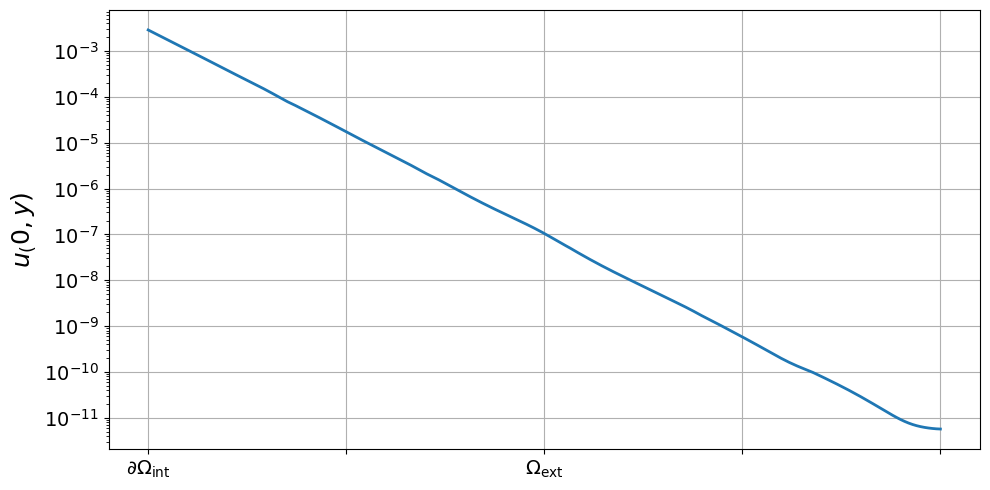

In [7]:
x_vals = np.linspace(1, 2, 200)
y_fixed = 0
points = [(x, y_fixed) for x in x_vals]

abs_vals = [abs(solution(mesh(x, y))) for (x, y) in points]

plt.figure(figsize=(10, 5))
plt.plot(x_vals, abs_vals, linewidth=2)


# Achsenbeschriftung
plt.grid(True)

# Benutzerdefinierte x-Achse
x_left = x_vals[0]
x_right = x_vals[-1]
tick_positions = np.linspace(x_left, x_right, 5)
tick_labels = [""] * 5
tick_labels[0] = r"$\partial\Omega_{\mathrm{int}}$"
tick_labels[2] = r"$\Omega_{\mathrm{ext}}$"
plt.xticks(tick_positions, tick_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.yscale("log")
plt.ylabel(r"${u}_(0,y)$", fontsize=18)
plt.tight_layout()
#plt.savefig("pml_decay_plot.png", dpi=300)
plt.show()